In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dustmaps.bayestar
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits, ascii
from dustmaps.config import config
from scipy.optimize import curve_fit 
import pandas as pd
from astropy.io import ascii
import os
config.reset()

In [2]:
#Loading Edenhofer 2023
from dustmaps.edenhofer2023 import fetch
fetch(fetch_samples = False)

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [3]:
#Load Edenhofer 2023
from dustmaps.edenhofer2023 import Edenhofer2023Query
E23 = Edenhofer2023Query(load_samples=False)
#E23 = dustmaps.edenhofer2023.Edenhofer2023Query(load_samples = True) #Edenhofer et al (2023)

Optimizing map for querying (this might take a couple of seconds)...


Could possibly create logarithmic gradient to scale the resolution, via O'neill 2025:

"sampling the dust in 516 logarithmically spaced distance bins spanning 69 pc to 1250 pc. "

In [4]:
def dust(l, b):
    '''
    Function calls coordinates and returns distance axis and differential Av. 
    To get total Av along a sightline, try np.sum(cdusts)*delta(dists).
    =========================================================================
    Parameters:
    l = galactic longitude (deg)
    b = galactic latitude (deg)

    Returns:
    dists = distance (pc)
    cdust = differential Av along sightline (mag)
    '''
    dists = np.linspace(100, 800, 700) #setting independent variable
    cdusts = np.zeros_like(dists) #array matching dists
    for i, d in enumerate(dists):
        if (i != 0):
            point = SkyCoord(l*u.deg, b*u.deg, distance = d*u.pc, frame = 'galactic')
            data = E23.query(point, mode = 'mean')
            cdusts[i] = data
    #dists = dists/1000 #pc to kpc conversion if necessary
    cdusts = cdusts-np.roll(cdusts, 1) #shifts values circularly within array

    return dists, cdusts

In [18]:
dists = np.linspace(100, 800, 3000)
point = SkyCoord(119.07*u.deg, 28*u.deg, distance = dists*u.pc, frame = 'galactic')
data = E23.query(point, mode = 'mean')
data2 = data-np.roll(data, 1)

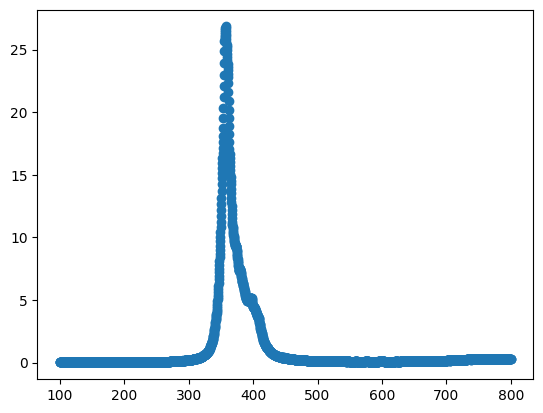

In [19]:
#print(data)
data = data*2.0407*1653
plt.scatter(dists, data)

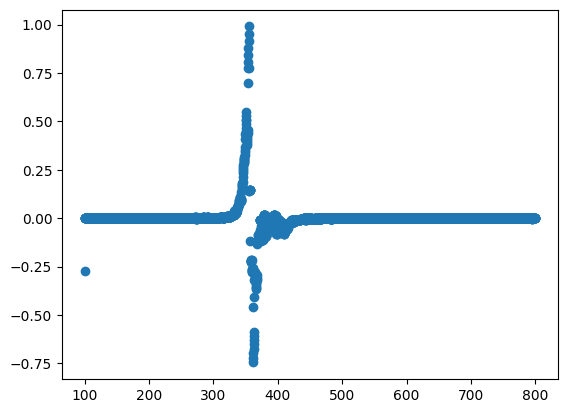

In [20]:
#print(data)
data2 = data2*2.0407*1653
plt.scatter(dists, data2)

In [5]:
def eden_dust(l, b, return_std = False):
    '''
    Function calls coordinates and returns distance axis and differential Av. 
    To get total Av along a sightline, try np.sum(cdusts)*delta(dists).
    =========================================================================
    Parameters:
    l = galactic longitude (deg)
    b = galactic latitude (deg)

    Returns:
    dists = distance (pc)
    cdust = differential Av along sightline (mag)
    '''
    dists = np.linspace(100, 800, 700)  # distance array in pc

    point = SkyCoord(l*u.deg, b*u.deg, distance=dists*u.pc, frame='galactic')

    cdust = E23.query(point, mode='mean')        # avg extinction
    if return_std:
        cdust_std = E23.query(point, mode='std')  # standard deviation
        return dists, cdust, cdust_std
    else:
        return dists, cdust

In [6]:
def Gauss(x, h, c, w):
    '''
    Performs Gaussian w/ respect to params
    ================================================
    Parameters:
    x = x axis values  
    h = height
    c = center
    w = width

    Returns:
    Gaussian function output
    '''
    G = h*np.exp(-(x-c)**2/(2*w**2))
    return G

In [7]:
def plotred(l, b, bounds=(-np.inf, np.inf)):
    """
    Plot the differential reddening for a given Galactic coordinate (l, b),
    fit a Gaussian to the extinction profile, compute column and volume density,
    and return all relevant parameters in a DataFrame.

    Parameters:
    - l: Galactic longitude [deg]
    - b: Galactic latitude [deg]
    - bounds: Tuple of lower and upper bounds for Gaussian fit parameters

    Returns:
    - df: Pandas DataFrame with extracted physical parameters
    """
    # --------------------- Load and Scale Data ---------------------
    dists, cdusts = eden_dust(l, b)                    # Load differential A_V data vs distance
    cdusts = cdusts*2.0407                        #ZGR23 conversion to G band extinction (Theo 2025)

    # Find peak extinction location (needed for Gaussian center guess)
    max_Av_val = np.max(cdusts)
    max_Av_loc = dists[np.where(cdusts == max_Av_val)]  # may return array of locations

    Theo_Scaling = 1653 #Scaling factor to convert Av to volume density, via equation 5 from O'neill, Theo 2025

    # --------------------- Fit Gaussian ---------------------
    x = np.linspace(np.min(dists), np.max(dists), 200)
    initial_guess = [0.2, float(max_Av_loc[0]), 50]       # height, center, width

    parameters, covariance = curve_fit(
        Gauss, dists, cdusts,
        p0=initial_guess,
        bounds=bounds
    )

    fit_h, fit_c, fit_w = parameters
    fit_y = Gauss(x, fit_h, fit_c, fit_w)

    # --------------------- Compute Integrated Extinction ---------------------
    tot_Av = fit_h * fit_w * np.sqrt(2 * np.pi)            # Area under Gaussian
    Av = tot_Av * u.mag

    # --------------------- Compute Column and Volume Density ---------------------
    ratio = 8.3e21 * u.cm**-2 / u.mag                      # From Liszt 2014a via Nguyen 2018
    NH = ratio * Av                                        # Column density [cm^-2]
    depth = fit_w * u.pc                                   # FWHM used as cloud depth
    volumeDensity = NH / depth                             # Volume density [cm^-3]
    volumeDensity = volumeDensity.to('cm**-3')             # Convert to scalar unit

    integrated_vol_density = tot_Av*Theo_Scaling              #Applies scaling factor from O'neill 2025

    # --------------------- Package Data into DataFrame ---------------------
    data = {
        'l [deg]': [l],
        'b [deg]': [b],
        'Total A_V [mag]': [tot_Av],
        'Distance of Peak A_V [pc]': [float(max_Av_loc[0])],
        'FWHM [pc]': [fit_w],
        'Column Density [cm^-2]': [NH.value],
        'Volume Density [cm^-3]': [volumeDensity.value],
        'Integrated Volume Density [cm^-3]': [integrated_vol_density]
    }
    df = pd.DataFrame(data)

    # --------------------- Plot ---------------------
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(dists, cdusts*Theo_Scaling, where='mid', label='Data')                     #Multiply by scaling factor from O'neill 2025 to have correct Axis
    ax.plot(x, fit_y*Theo_Scaling, '--', color='crimson', label='Gaussian Fit')
    ax.set_xlabel('Distance (pc)', fontsize=12)
    ax.set_ylabel(r'Volume Density (Converted) [cm$^{-3}$]', fontsize=12)
    ax.set_title(f'Differential Volume Density Toward l={l}, b={b}', fontsize=12)
    ax.set_xlim([0, 800])
    ax.set_ylim([0, np.max(cdusts*Theo_Scaling) * 1.1])                                #Multiply by scaling factor form O'neill 2025 
    ax.legend()
    ax.grid(True, linestyle='--')
    plt.show()

    # --------------------- Save Data ---------------------
    folder = "E23 Mapped Dust Outputs"
    filename = os.path.join(folder, f"Edenhofer23_l{l}_b{b}_mapped.csv")
    df.to_csv(filename, index=False)

    # --------------------- Debug Output ---------------------
    print(f"Amplitude (fit height): {fit_h:.4f} mag")
    print(f"Total A_V (integrated): {tot_Av:.4f} mag")
    print(f"Volume Density: {volumeDensity:.2f}")
    print(f"Integrated Volume Density: {integrated_vol_density:.2f} cm^-3")
    print(f"Saved CSV to: {filename}")
    print('Max Av:', np.max(cdusts))
    print('Max Volume Density:', np.max(cdusts)*Theo_Scaling)
    print('Gaussian Height:', fit_h)
    print('Gaussian Width:', fit_w)

    return df

In [8]:
def eden_fit(l, b, bounds = (-np.inf, np.inf)):
    """
    Plot the extinction for given galactic coordinate (l, b),
    fit Gaussian to extinction profile, compute volume density,
    return relevant parameters in a dataframe

    Params:
    - l: Galactic longitude [deg]
    - b: Galactic latitude [deg]
    - bounds: Tuple of lower and upper bounds for Gaussian fit params

    Returns:
    - df: Pandas DataFrame w/ extracted physical params
    """
    
    #--------------ZGR23 to G Band--------------
    
    #-------Load and Scale Data-------
    dists, cdusts, cdusts_std = eden_dust(l, b, return_std = True)    #Load extinction in ZGR23 band (A_ZGR23) and distance (dists)
    cdusts_G = cdusts*2.0407             #Conversion from ZGR23 to G band (Theo O'neill 2025)
    cdusts_G_std = cdusts_std*2.0407

    n = len(cdusts)
    n_std = len(cdusts_std)

    #-------Find peak extinction location-------
    max_AG_val = np.max(cdusts_G)
    max_AG_loc = dists[np.where(cdusts_G == max_AG_val)]
 
    Theo_Scaling = 1653                #Scaling factor to convert from G band extinction to volume density (O'neill 2025)

    #-------Gaussian Fit-------
    x = np.linspace(np.min(dists), np.max(dists), 200)
    initial_guess = [0.2, 320, 50]       #height, center, width

    parameters, covariance = curve_fit(Gauss, dists, cdusts_G, p0 = initial_guess, bounds = bounds)
    parameters_std, covariance_std = curve_fit(Gauss, dists, cdusts_G_std, p0 = initial_guess, bounds = bounds)

    Gfit_h, Gfit_c, Gfit_w = parameters                      #height, center, width
    Gfit_y = Gauss(x, Gfit_h, Gfit_c, Gfit_w)

    Gfit_h_std, Gfit_c_std, Gfit_w_std = parameters_std
    Gfit_y_std = Gauss(x, Gfit_h_std, Gfit_c_std, Gfit_w_std)

    #-------Compute Integrated Extinction-------
    lo_G = Gfit_c - 3*Gfit_w
    hi_G = Gfit_c + 3*Gfit_w
    mask_G = (dists >= lo_G) & (dists <= hi_G)
    tot_AG = np.sum(cdusts_G[mask_G])
    tot_AG_std = np.sqrt(np.sum(cdusts_G_std[mask_G]**2))   #variance = sum of variances

    #tot_AG_std = Gfit_h_std* Gfit_w_std*np.sqrt(2*np.pi)
    #AG_std = tot_AG_std * u.mag

    #-------Compute Volume Density-------
    volume_density_G = tot_AG*Theo_Scaling             #Applying scaling factor to compute volume density
    volume_density_G_std = tot_AG_std*Theo_Scaling
    
    volume_density_G_std_profile = cdusts_G_std * Theo_Scaling           #volume density profile
    sdom_voldens_G = volume_density_G_std/np.sqrt(12)  #sdom = average std / sqrt(n), where n is number of elements

    #--------------ZGR23 to V Band--------------

    #-------Load and Scale Data-------
    cdusts_V = cdusts*2.6558             #Conversion from ZGR23 to V band
    cdusts_V_std = cdusts_std*2.6558

    #-------Find peak extinction location-------
    max_AV_val = np.max(cdusts_V)
    max_AV_loc = dists[np.where(cdusts_V == max_AV_val)]

    #-------Gaussian Fit-------
    initial_guess_V = [0.2, 300, 50]

    parameters_V, covariance_V = curve_fit(
        Gauss, dists, cdusts_V,
        p0 = initial_guess_V,
        bounds = bounds
    )

    parameters_V_std, covariance_V_std = curve_fit(Gauss, dists, cdusts_V_std, p0 = initial_guess_V,
        bounds = bounds
    )

    Vfit_h, Vfit_c, Vfit_w = parameters_V
    Vfit_Y = Gauss(x, Vfit_h, Vfit_c, Vfit_w)

    Vfit_h_std, Vfit_c_std, Vfit_w_std = parameters_V_std
    Vfit_Y_std = Gauss(x, Vfit_h_std, Vfit_c_std, Vfit_w_std)

    #-------Compute Integrated Extinction-------
    lo_V = Vfit_c - 3*Vfit_w
    hi_V = Vfit_c + 3*Vfit_w
    
    mask_V = (dists >= lo_V) & (dists <= hi_V)
    if not np.any(mask_V):  # safety: ensure at least one point
        idx_v = np.argmin(np.abs(dists - Vfit_c))
        mask_V[idx_v] = True
    
    # Discrete sum over raw extinction values in the window
    tot_AV = np.sum(cdusts_V[mask_V])
    AV = tot_AV * u.mag

    tot_AV_std = np.sqrt(np.sum(cdusts_V_std[mask_V]**2))
    AV_std = tot_AV_std * u.mag
    
    #tot_AV = Vfit_h*Vfit_w*np.sqrt(2*np.pi)
    #AV = tot_AV*u.mag

    #tot_AV_std = Vfit_h_std*Vfit_w_std*np.sqrt(2*np.pi)
    #AV_std = tot_AV_std * u.mag
    
    #-------Compute Column and Volume Density-------
    ratio = 8.3e21*u.cm**-2/u.mag               #From Liszt 2014a via Nguyen 2018
    NH = ratio * AV                             #Column Density
    depth = Vfit_w*u.pc                         #Width as cloud depth
    volume_density_V = NH/depth
    volume_density_V = volume_density_V.to('cm**-3') #applies cm-parsec conversion scaling

    NH_std = ratio * AV_std                             #Column Density
    depth_std = Vfit_w_std*u.pc                         #Width as cloud depth
    volume_density_V_std = NH_std/depth_std
    volume_density_V_std = volume_density_V_std.to('cm**-3') #applies cm-parsec conversion scaling
    

    NH_G = tot_AG/(4*10**-22) #convert G band extinction to N(H)

    #-------Uncertainties-------
    sigma_Vfit_w = np.sqrt(np.diag(covariance_V))[2]  # index 2 is for width
    #volume_density_V_std = volume_density_V.value * (sigma_Vfit_w / Vfit_w)

    

    #-------DataFrame-------
    data = {
        'l [deg]': [l],
        'b [deg]': [b],
        'Total A_V [mag]': [tot_AV],
        'Total A_G [mag]': [tot_AG],
        'Distance to Peak': [float(max_AG_loc[0])],
        'FWHM (V Band) [pc]': [Vfit_w],
        'Column Density [cm^-2]': [NH.value],
        'V Band Volume Density [cm^-3]': [volume_density_V.value],
        'G Band Volume Density [cm^-3]': [volume_density_G],
        'N(H) from A_G [cm^-2]': NH_G,
        #'V Band Volume Density Error': volume_density_V_std,
        'G Band Volume Density Std': volume_density_G_std,
        'G Band Volume Density SDOM': sdom_voldens_G,
        'V Band Volume Density STD': volume_density_V_std
    }
    df = pd.DataFrame(data)

    #-------Plotting-------
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(dists, cdusts_G * Theo_Scaling, where='mid', label='Data')
    ax.plot(x, Gfit_y * Theo_Scaling, '--', color='crimson', label='Gaussian Fit')
    
    # Highlight integrated regions
    lo_G = Gfit_c - 3*Gfit_w
    hi_G = Gfit_c + 3*Gfit_w
    ax.axvspan(lo_G, hi_G, color='black', alpha=0.3, label='Integration Region')
    
    ax.set_xlabel('Distance (pc)', fontsize=12)
    ax.set_ylabel(r'Volume Density (Converted) [cm$^{-3}$]', fontsize=12)
    ax.set_title(f'Differential Volume Density Toward l={l}, b={b}', fontsize=12)
    ax.set_xlim([0, 800])
    ax.set_ylim([0, np.max(cdusts_G * Theo_Scaling) * 1.1])
    ax.legend()
    ax.grid(True, linestyle='--')
    plt.show()


    '''fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(dists, cdusts_G*Theo_Scaling, where='mid', label='Data')                     #Multiply by scaling factor from O'neill 2025 to have correct Axis
    ax.plot(x, Gfit_y*Theo_Scaling, '--', color='crimson', label='Gaussian Fit')
    ax.set_xlabel('Distance (pc)', fontsize=12)
    ax.set_ylabel(r'Volume Density (Converted) [cm$^{-3}$]', fontsize=12)
    ax.set_title(f'Differential Volume Density Toward l={l}, b={b}', fontsize=12)
    ax.set_xlim([0, 800])
    ax.set_ylim([0, np.max(cdusts_G*Theo_Scaling) * 1.1])                                #Multiply by scaling factor form O'neill 2025 
    ax.legend()
    ax.grid(True, linestyle='--')
    plt.show()    '''
    
    # --------------------- Save Data ---------------------
    folder = "E23 Mapped Dust Outputs"
    filename = os.path.join(folder, f"Edenhofer23_l{l}_b{b}_mapped.csv")
    df.to_csv(filename, index=False)
    
    
    # --------------------- Debug Output ---------------------
    print(f"Amplitude (fit height): {Vfit_h:.4f} mag")
    print(f"Total A_V (integrated): {tot_AV:.4f} mag")
    print(f"Total A_G (integrated): {tot_AG:.4f} mag")
    print(f"Saved CSV to: {filename}")
    print('Max Av:', np.max(cdusts_V))
    print('Max G Volume Density:', np.max(cdusts_G)*Theo_Scaling)
    print('Gaussian Height:', Vfit_h)
    print('Gaussian Width:', Vfit_w)

    return df 

In [9]:
def edenfinder(l, b):
    # --------------------- Load and Scale Data ---------------------
    dists, cdustsZGR23 = eden_dust(l, b)                    # Load extinction data vs distance
    cdusts = cdustsZGR23 * 2.0407                      # ZGR23 conversion to G band extinction (Theo 2025)

    Theo_Scaling = 1653                           # Conversion from A_G to volume density [cm^-3 mag^-1 pc^-1]

    Theo_ZGR_Vconv = 2.6558                          # Conversion from ZGR23 to A_V [mag]

    # --------------------- Find Peak and Integration Bounds ---------------------
    max_idx = np.argmax(cdusts)
    max_dist = dists[max_idx]

    # Integration bounds
    lower_bound = max_dist - 50
    upper_bound = max_dist + 50

    # Mask for integration range
    mask = (dists >= lower_bound) & (dists <= upper_bound)
    delta_d = 1                                              # Distance step size in pc

    # Integrate A_G over ±50 pc
    integrated_AG = np.sum(cdusts[mask]) * delta_d  # Total A_G
    integrated_AG = round(integrated_AG, 6)
    Av = round(integrated_AG/2.0407 * Theo_ZGR_Vconv, 6)   #Going from G band, dividing to get to ZGR23, then multiplying to get to V band
    
    # Compute volume density using scaling factor
    volumeDensity = integrated_AG * Theo_Scaling  # Volume density [cm^-3]

    # --------------------- Package Data into DataFrame ---------------------
    data = {
        'l [deg]': [l],
        'b [deg]': [b],
        'Total A_V [mag]': [Av],
        'Total A_G [mag]': [integrated_AG],
        'Distance of Peak A_V [pc]': [max_dist],
        'Volume Density [cm^-3]': [volumeDensity]
    }
    df = pd.DataFrame(data)

    # --------------------- Plot ---------------------
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(dists, cdusts*Theo_Scaling, where='mid', label='Volume Density [cm^-3]')
    ax.axvspan(lower_bound, upper_bound, color='orange', alpha=0.3, label='Integration Range')
    ax.set_xlabel('Distance (pc)', fontsize=12)
    ax.set_ylabel(r'Differential A_V [mag]', fontsize=12)
    ax.set_title(f'Differential A_V Toward l={l}, b={b}', fontsize=12)
    ax.set_xlim([0, 800])
    ax.set_ylim([np.min(cdusts)*Theo_Scaling*1.1, np.max(cdusts)*Theo_Scaling * 1.1])
    ax.legend()
    ax.grid(True, linestyle='--')
    plt.show()

    # --------------------- Save Data ---------------------
    folder = "E23 Mapped Dust Outputs"
    os.makedirs(folder, exist_ok=True)
    filename = os.path.join(folder, f"Edenhofer2023_l{l}_b{b}_mapped.csv")
    df.to_csv(filename, index=False)

    # --------------------- Debug Output ---------------------
    print(f"Total A_V (±50 pc): {Av:.6f} mag")
    print(f"Total A_G (±50 pc): {integrated_AG:.4f} mag")
    print(f"Volume Density (scaled): {volumeDensity:.2f} cm^-3")
    print(f"Saved CSV to: {filename}")
    print('Max Av Distance:', max_dist)
    print('Max Av:', np.max(cdusts))
    print('Masked Channels:', len(cdusts[mask]))
    print(cdusts[mask])
    print(dists[mask])

    return df

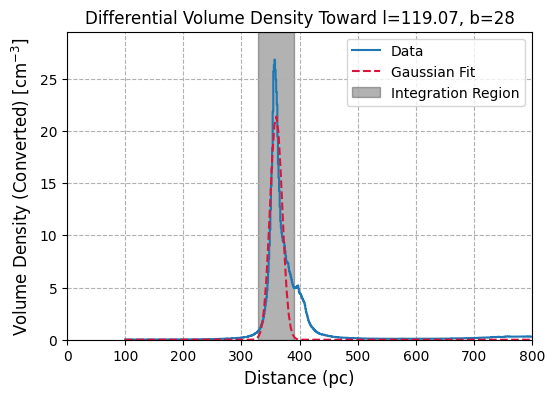

Amplitude (fit height): 0.0168 mag
Total A_V (integrated): 0.4697 mag
Total A_G (integrated): 0.3609 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l119.07_b28_mapped.csv
Max Av: 0.02111156887477126
Max G Volume Density: 26.814960400007024
Gaussian Height: 0.016848829336551466
Gaussian Width: 10.407417733660184


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,119.07,28,0.469744,0.360949,357.367668,10.407418,3.898878e+21,121.407654,596.647957,9.023714e+20,40.479843,11.685524,6.76082


In [11]:
eden_fit(119.07, 28, bounds = [(0, 290, 0), (1, 365, 80)])

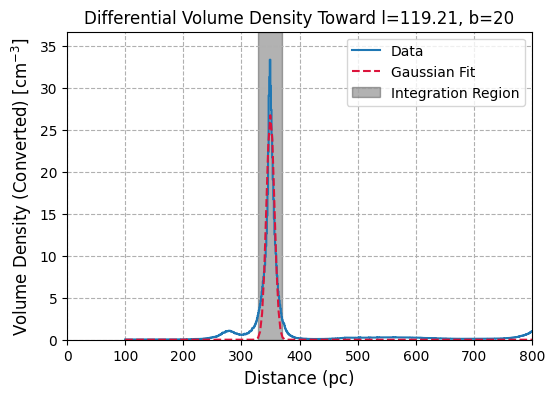

Amplitude (fit height): 0.0211 mag
Total A_V (integrated): 0.3882 mag
Total A_G (integrated): 0.2983 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l119.21_b20_mapped.csv
Max Av: 0.026267228911072676
Max G Volume Density: 33.36344670765095
Gaussian Height: 0.021067208627705787
Gaussian Width: 6.8878545038279855


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,119.21,20,0.388212,0.298299,349.356223,6.887855,3.222156e+21,151.604472,493.088737,7.457482e+20,44.945995,12.974791,13.990507


In [12]:
eden_fit(119.21, 20, bounds = [(0, 290, 0), (1, 380, 80)])

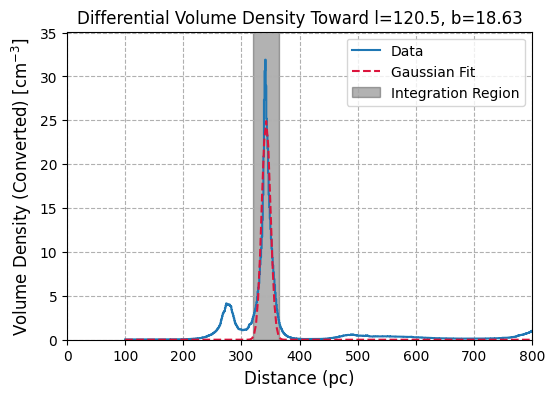

Amplitude (fit height): 0.0196 mag
Total A_V (integrated): 0.3909 mag
Total A_G (integrated): 0.3004 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l120.5_b18.63_mapped.csv
Max Av: 0.025114602150303495
Max G Volume Density: 31.89943230259415
Gaussian Height: 0.019620557594001404
Gaussian Width: 7.529476096509864


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,120.5,18.63,0.390932,0.30039,341.344778,7.529476,3.244734e+21,139.65735,496.543911,7.509739e+20,41.246039,11.906706,13.095626


In [13]:
eden_fit(120.5, 18.63, bounds = [(0, 300, 0), (1, 400, 80)])

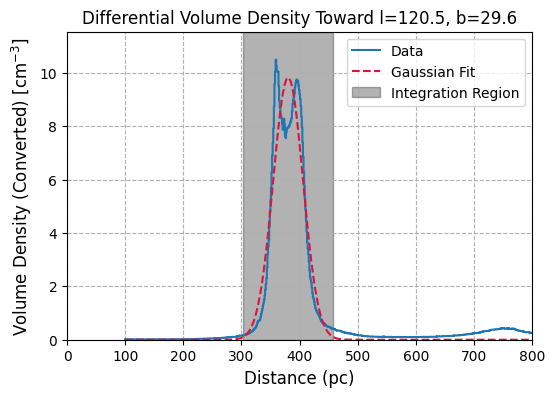

Amplitude (fit height): 0.0077 mag
Total A_V (integrated): 0.4873 mag
Total A_G (integrated): 0.3744 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l120.5_b29.6_mapped.csv
Max Av: 0.008266467817302213
Max G Volume Density: 10.499693721662979
Gaussian Height: 0.007741557062521957
Gaussian Width: 25.689781907154227


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,120.5,29.6,0.487277,0.374421,359.370529,25.689782,4.044402e+21,51.020336,618.917603,9.360520e+20,31.681095,9.145544,2.4874


In [42]:
eden_fit(120.5, 29.6, bounds = [(0, 300, 0), (12, 420, 150)])

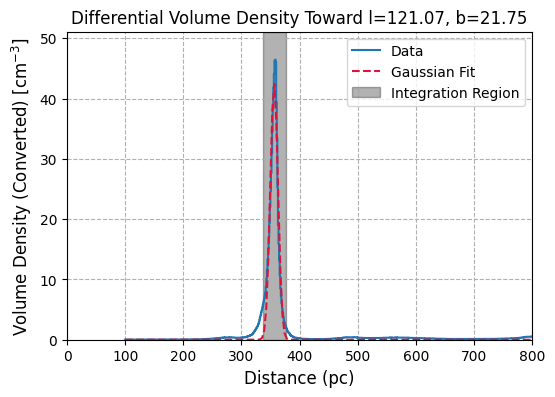

Amplitude (fit height): 0.0334 mag
Total A_V (integrated): 0.0347 mag
Total A_G (integrated): 0.4431 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l121.07_b21.75_mapped.csv
Max Av: 0.03655565089019172
Max G Volume Density: 46.43133519974334
Gaussian Height: 0.033440941846925434
Gaussian Width: -6.630407324930602


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,121.07,21.75,0.03471,0.443083,358.369099,-6.630407,2.880928e+20,-14.081266,732.415842,1.107707e+21,65.28853,18.847175,-5.894531


In [15]:
eden_fit(121.07, 21.75)

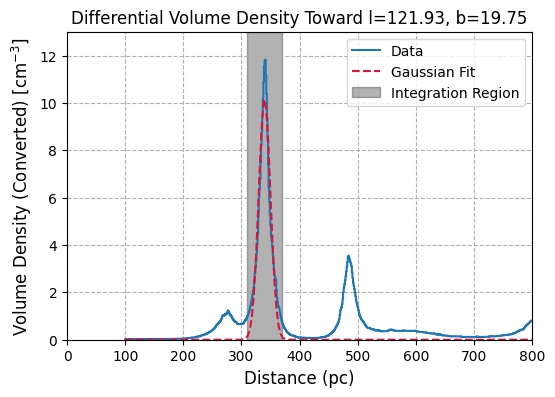

Amplitude (fit height): 0.0080 mag
Total A_V (integrated): 0.2119 mag
Total A_G (integrated): 0.1628 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l121.93_b19.75_mapped.csv
Max Av: 0.009310510561435795
Max G Volume Density: 11.825789617516193
Gaussian Height: 0.008010626326592031
Gaussian Width: 10.086364567932478


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,121.93,19.75,0.211886,0.162812,341.344778,10.086365,1.758656e+21,56.506153,269.128386,4.070302e+20,17.909108,5.169914,3.070992


In [16]:
eden_fit(121.93, 19.75, bounds = [(0, 300, 0), (12, 360, 60)])

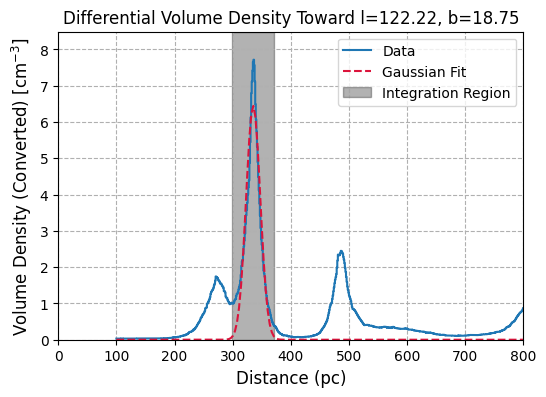

Amplitude (fit height): 0.0051 mag
Total A_V (integrated): 0.1633 mag
Total A_G (integrated): 0.1255 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l122.22_b18.75_mapped.csv
Max Av: 0.006074371701982574
Max G Volume Density: 7.715392333453513
Gaussian Height: 0.005074123663101199
Gaussian Width: 12.215312592682405


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,122.22,18.75,0.163291,0.125472,336.337625,12.215313,1.355315e+21,35.95715,207.404869,3.136795e+20,13.914701,4.016828,2.294225


In [17]:
eden_fit(122.22, 18.75, bounds = [(0, 300, 0), (12, 400, 80)])

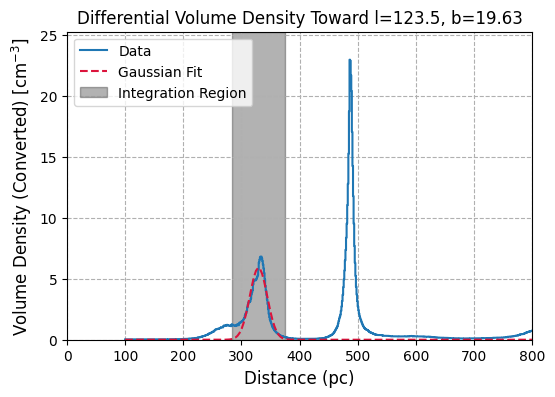

Amplitude (fit height): 0.0046 mag
Total A_V (integrated): 0.1818 mag
Total A_G (integrated): 0.1396 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l123.5_b19.63_mapped.csv
Max Av: 0.018082532347572317
Max G Volume Density: 22.96761513595713
Gaussian Height: 0.004641044863052045
Gaussian Width: 14.98337011390868


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,123.5,19.63,0.18179,0.139551,486.552217,14.98337,1.508860e+21,32.635394,230.678294,3.488782e+20,14.565784,4.20478,1.914361


In [18]:
eden_fit(123.5, 19.63, bounds = [(0, 280, 0), (12, 380, 60)])

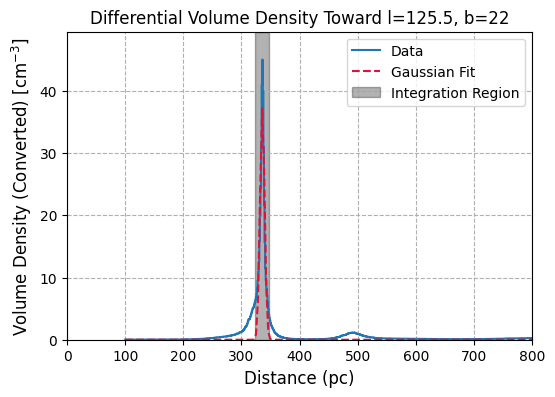

Amplitude (fit height): 0.0294 mag
Total A_V (integrated): 0.3138 mag
Total A_G (integrated): 0.2411 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l125.5_b22_mapped.csv
Max Av: 0.03544829688574447
Max G Volume Density: 45.024824203133946
Gaussian Height: 0.029390825278898997
Gaussian Width: 3.9519764416006558


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,125.5,22,0.313831,0.241146,336.337625,3.951976,2.604801e+21,213.604111,398.614468,6.028652e+20,39.696619,11.459427,15.947312


In [19]:
eden_fit(125.5, 22)

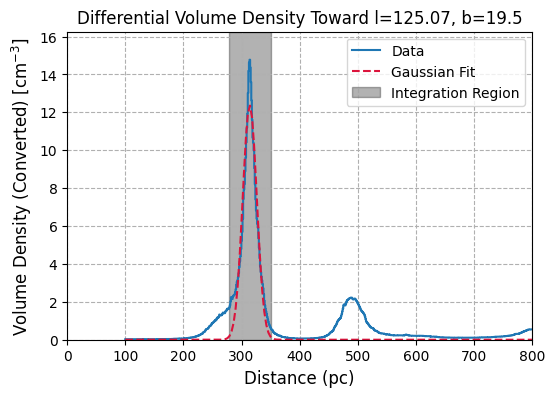

Amplitude (fit height): 0.0097 mag
Total A_V (integrated): 0.3110 mag
Total A_G (integrated): 0.2389 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l125.07_b19.5_mapped.csv
Max Av: 0.011635046506600587
Max G Volume Density: 14.778310090425016
Gaussian Height: 0.009734480686924242
Gaussian Width: 12.126590490986688


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,125.07,19.5,0.310972,0.238949,314.306152,12.12659,2.581068e+21,68.977929,394.982603,5.973724e+20,24.726127,7.137818,3.73622


In [20]:
eden_fit(125.07, 19.5)

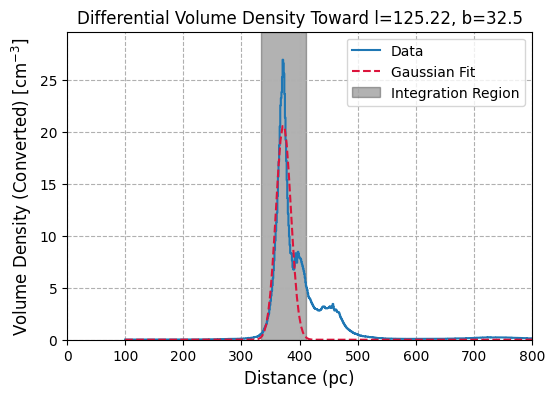

Amplitude (fit height): 0.0163 mag
Total A_V (integrated): 0.5733 mag
Total A_G (integrated): 0.4405 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l125.22_b32.5_mapped.csv
Max Av: 0.021201203943807274
Max G Volume Density: 26.928810812589337
Gaussian Height: 0.01628256588323199
Gaussian Width: 12.881717069734371


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,125.22,32.5,0.573307,0.440526,371.387697,12.881717,4.758451e+21,119.712992,728.189056,1.101314e+21,53.033252,15.309381,7.669449


In [21]:
eden_fit(125.22, 32.5, bounds = [(0, 300, 0), (28, 400, 100)])

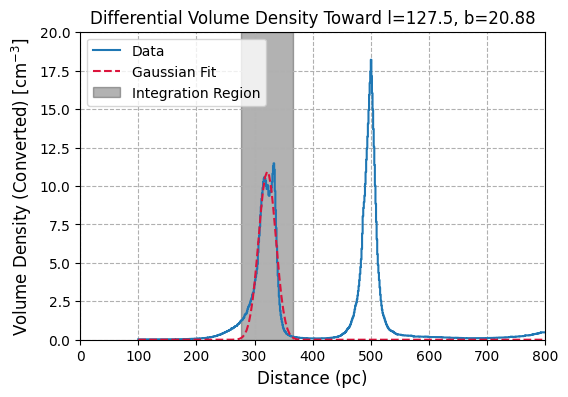

Amplitude (fit height): 0.0086 mag
Total A_V (integrated): 0.3232 mag
Total A_G (integrated): 0.2483 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l127.5_b20.88_mapped.csv
Max Av: 0.014338670175074147
Max G Volume Density: 18.21233065216907
Gaussian Height: 0.008608813631373243
Gaussian Width: 14.81497137607315


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,127.5,20.88,0.323185,0.248333,500.572246,14.814971,2.682436e+21,58.678357,410.494995,6.208333e+20,23.934637,6.909335,3.204312


In [22]:
eden_fit(127.5, 20.88, bounds = [(0, 280, 0), (13, 350, 80)])

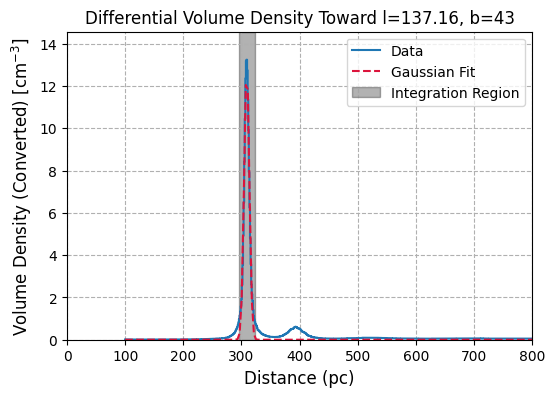

Amplitude (fit height): 0.0102 mag
Total A_V (integrated): 0.1172 mag
Total A_G (integrated): 0.0000 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l137.16_b43_mapped.csv
Max Av: 0.010428273783532508
Max G Volume Density: 13.245521931817368
Gaussian Height: 0.010165281911725476
Gaussian Width: 4.469286617870359


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,137.16,43,0.117213,0.0,309.298999,4.469287,9.728679e+20,70.544821,0.0,0.0,0.0,0.0,7.132861


In [23]:
eden_fit(137.16, 43)

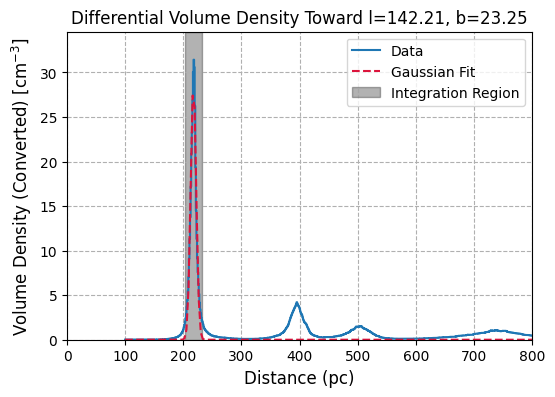

Amplitude (fit height): 0.0226 mag
Total A_V (integrated): 0.2778 mag
Total A_G (integrated): 0.2135 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l142.21_b23.25_mapped.csv
Max Av: 0.024740189821581885
Max G Volume Density: 31.423870688604286
Gaussian Height: 0.022610037778754442
Gaussian Width: 4.727885600697054


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,142.21,23.25,0.277817,0.213472,218.168813,4.727886,2.305877e+21,158.058793,352.869989,5.336812e+20,34.000532,9.815108,14.689324


In [24]:
eden_fit(142.21, 23.25, bounds = [(0, 200, 0), (35, 350, 60)])

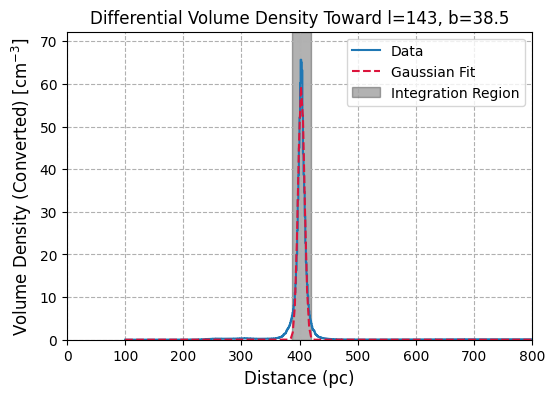

Amplitude (fit height): 0.0471 mag
Total A_V (integrated): 0.6717 mag
Total A_G (integrated): 0.5162 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l143_b38.5_mapped.csv
Max Av: 0.051715618802760134
Max G Volume Density: 65.68684110990291
Gaussian Height: 0.04705491593998145
Gaussian Width: 5.495053057884955


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,143,38.5,0.671728,0.516151,402.432046,5.495053,5.575340e+21,328.812985,853.198246,1.290378e+21,92.393918,26.671827,-33.023924


In [25]:
eden_fit(143, 38.5)

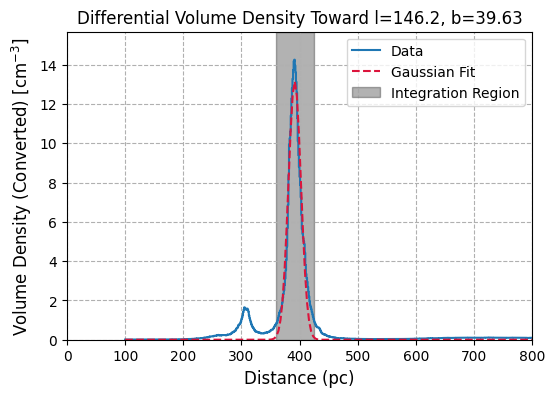

Amplitude (fit height): 0.0104 mag
Total A_V (integrated): 0.2896 mag
Total A_G (integrated): 0.2225 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l146.2_b39.63_mapped.csv
Max Av: 0.011225211494345159
Max G Volume Density: 14.257756185153742
Gaussian Height: 0.010353112300037033
Gaussian Width: 10.788840207249741


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,146.2,39.63,0.28962,0.222542,391.416309,10.78884,2.403843e+21,72.207259,367.861826,5.563548e+20,26.270542,7.583652,-4.260569


In [26]:
eden_fit(146.2, 39.63)

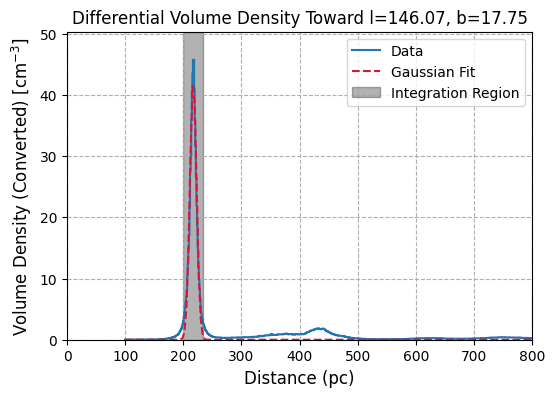

Amplitude (fit height): 0.0333 mag
Total A_V (integrated): 0.4957 mag
Total A_G (integrated): 0.3809 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l146.07_b17.75_mapped.csv
Max Av: 0.03601029179311152
Max G Volume Density: 45.73864472852663
Gaussian Height: 0.03325890702010033
Gaussian Width: 5.737226621310032


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,146.07,17.75,0.495681,0.380878,217.167382,5.737227,4.114155e+21,232.395701,629.591998,9.521960e+20,61.267141,17.6863,-22.476908


In [27]:
eden_fit(146.07, 17.75)

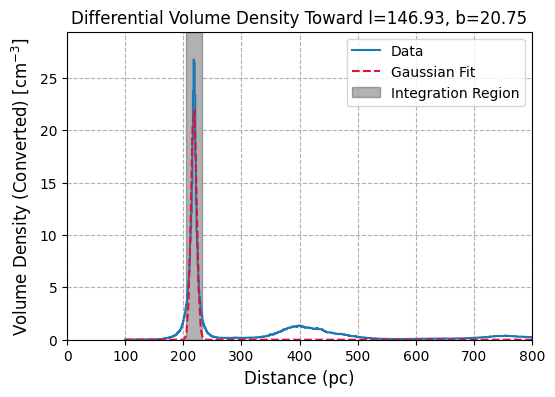

Amplitude (fit height): 0.0179 mag
Total A_V (integrated): 0.2275 mag
Total A_G (integrated): 0.1748 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l146.93_b20.75_mapped.csv
Max Av: 0.021056042064549408
Max G Volume Density: 26.744432755848045
Gaussian Height: 0.01792170055976785
Gaussian Width: 4.734674911297828


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,146.93,20.75,0.227471,0.174787,218.168813,4.734675,1.888010e+21,129.23007,288.923488,4.369684e+20,30.113873,8.693126,11.798645


In [28]:
eden_fit(146.93, 20.75, bounds = [(0, 200, 0), (30, 350, 60)])

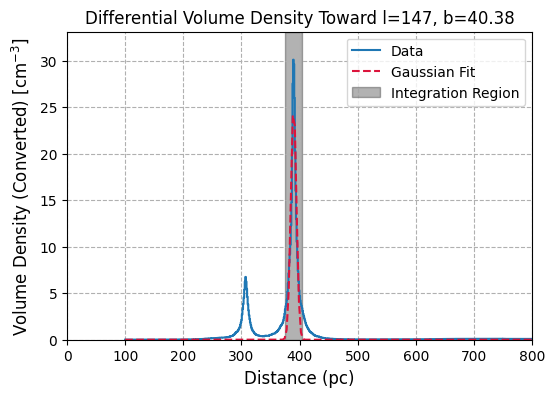

Amplitude (fit height): 0.0199 mag
Total A_V (integrated): 0.2536 mag
Total A_G (integrated): 0.1949 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l147_b40.38_mapped.csv
Max Av: 0.02369685834646874
Max G Volume Density: 30.098678214506688
Gaussian Height: 0.01988501121517943
Gaussian Width: 4.783466925880644


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,147,40.38,0.253649,0.194902,389.413448,4.783467,2.105283e+21,142.632089,322.172987,4.872550e+20,45.434012,13.11567,35.003644


In [29]:
eden_fit(147, 40.38)

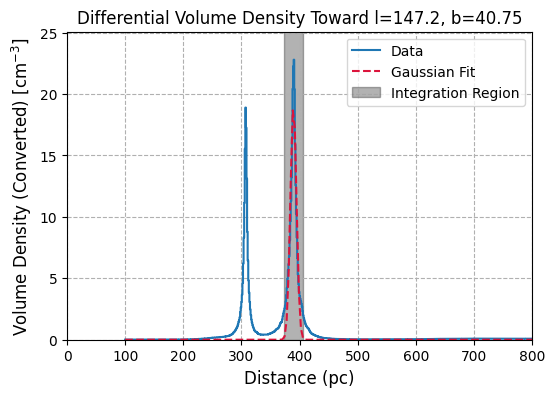

Amplitude (fit height): 0.0151 mag
Total A_V (integrated): 0.2104 mag
Total A_G (integrated): 0.1617 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l147.2_b40.75_mapped.csv
Max Av: 0.017940989740485833
Max G Volume Density: 22.787834115112513
Gaussian Height: 0.015051098887146869
Gaussian Width: 5.237283093018963


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,147.2,40.75,0.210445,0.161705,390.414878,5.237283,1.746693e+21,108.083637,267.297627,4.042614e+20,27.770045,8.016522,10.550183


In [30]:
eden_fit(147.2, 40.75)

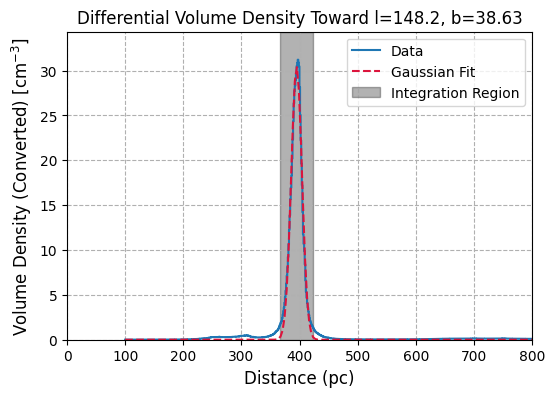

Amplitude (fit height): 0.0239 mag
Total A_V (integrated): 0.5676 mag
Total A_G (integrated): 0.4361 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l148.2_b38.63_mapped.csv
Max Av: 0.02456943837973054
Max G Volume Density: 31.206989926276883
Gaussian Height: 0.02394576780890225
Gaussian Width: 9.282807462671732


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,148.2,38.63,0.567587,0.43613,397.424893,9.282807,4.710970e+21,164.467636,720.923028,1.090325e+21,60.677093,17.515968,-13.857923


In [31]:
eden_fit(148.2, 38.63)

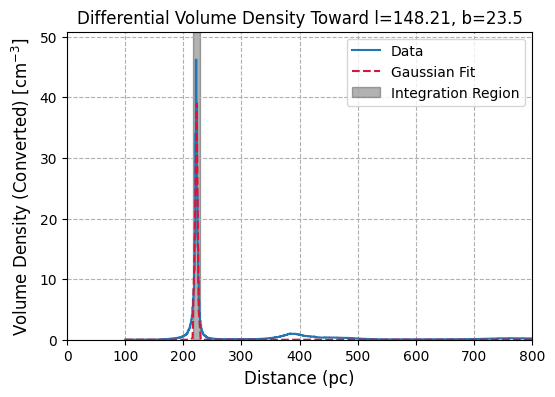

Amplitude (fit height): 0.0326 mag
Total A_V (integrated): 0.1748 mag
Total A_G (integrated): 0.1343 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l148.21_b23.5_mapped.csv
Max Av: 0.03637178747098543
Max G Volume Density: 46.19780019652913
Gaussian Height: 0.03255175681133293
Gaussian Width: 2.029625429503062


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,148.21,23.5,0.174758,0.134283,222.174535,2.029625,1.450493e+21,231.605697,221.969978,3.357078e+20,26.243735,7.575914,20.883006


In [32]:
eden_fit(148.21, 23.5, bounds = [(0, -200, 0), (10, 320, 50)])

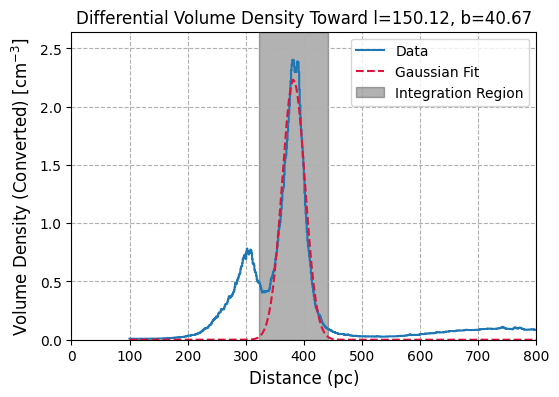

Amplitude (fit height): 0.0018 mag
Total A_V (integrated): 0.0906 mag
Total A_G (integrated): 0.0696 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l150.12_b40.67_mapped.csv
Max Av: 0.0018919318327345954
Max G Volume Density: 2.4030462859118313
Gaussian Height: 0.0017582769315222363
Gaussian Width: 19.676907395473037


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,150.12,40.67,0.090565,0.069589,381.402003,19.676907,7.516878e+20,12.38027,115.031311,1.739735e+20,6.56253,1.894439,0.646951


In [33]:
eden_fit(150.12, 40.67)

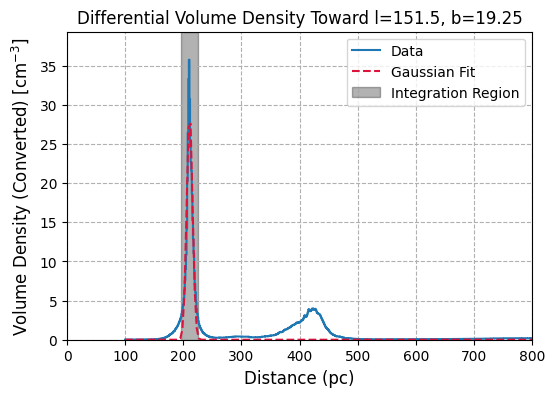

Amplitude (fit height): 0.0229 mag
Total A_V (integrated): 0.3006 mag
Total A_G (integrated): 0.2310 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l151.5_b19.25_mapped.csv
Max Av: 0.0281540877694679
Max G Volume Density: 35.76004953088943
Gaussian Height: 0.02291230497307891
Gaussian Width: 4.992025060031542


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,151.5,19.25,0.300567,0.230954,210.157368,4.992025,2.494706e+21,161.954146,381.766602,5.773845e+20,39.524569,11.40976,16.765466


In [34]:
eden_fit(151.5, 19.25, bounds = [(0, 190, 0), (40, 320, 60)])

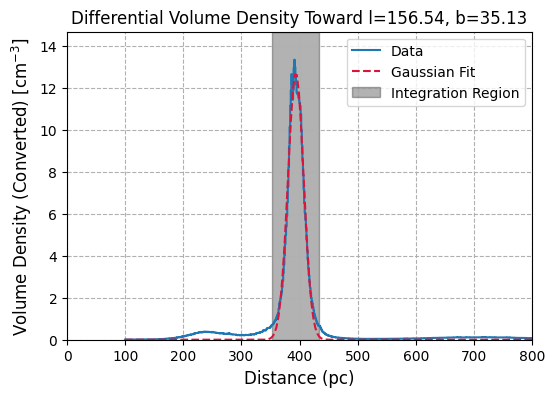

Amplitude (fit height): 0.0100 mag
Total A_V (integrated): 0.3436 mag
Total A_G (integrated): 0.2640 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l156.54_b35.13_mapped.csv
Max Av: 0.010502870053982231
Max G Volume Density: 13.340270742290093
Gaussian Height: 0.010023570525605633
Gaussian Width: 13.471765794479115


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,156.54,35.13,0.343603,0.264022,391.416309,13.471766,2.851906e+21,68.605679,436.429096,6.600561e+20,32.133695,9.276199,5.076979


In [35]:
eden_fit(156.54, 35.13, bounds = [(0, 299, 0), (14, 450, 120)])

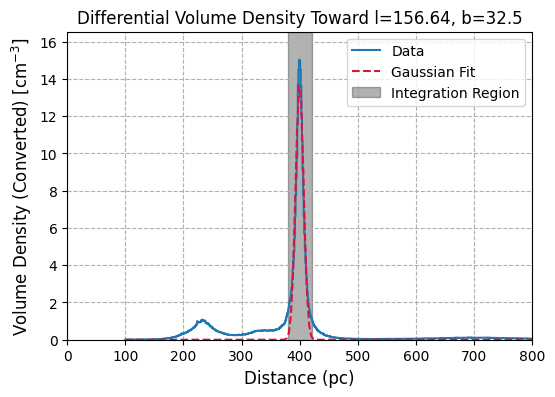

Amplitude (fit height): 0.0108 mag
Total A_V (integrated): 0.1966 mag
Total A_G (integrated): 0.1511 mag
Saved CSV to: E23 Mapped Dust Outputs/Edenhofer23_l156.64_b32.5_mapped.csv
Max Av: 0.011835515862570816
Max G Volume Density: 15.032937203816886
Gaussian Height: 0.010848734626536667
Gaussian Width: 6.889500345361887


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,156.64,32.5,0.196604,0.15107,399.427754,6.8895,1.631817e+21,76.759668,249.718041,3.776740e+20,26.325936,7.599643,8.498344


In [36]:
eden_fit(156.64, 32.5, bounds = [(0, 290, 0), (20, 450, 60)])

### Compile datasets into table and do volume density plot and stuff


In [37]:
from glob import glob

In [40]:
def csv_combine(folder = "E23 Mapped Dust Outputs", output = "E23 Master DF.csv"):
    # gather csvs
    csv_files = glob(os.path.join(folder, "*.csv"))
    
    # Load and concatenate only the first row of each CSV
    dfs = [pd.read_csv(i).iloc[[0]] for i in csv_files]  # use [[0]] to keep it as a DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Drop duplicates based on 'l' and 'b', keeping the first occurrence
    combined_df = combined_df.drop_duplicates(subset=['l [deg]', 'b [deg]'], keep='first')

    # Save out to master file
    combined_df.to_csv(os.path.join(folder, output), index=False)
    
    print(f"Combined {len(csv_files)} files into '{output}' with {len(combined_df)} rows.")
    return combined_df

In [41]:
folder = "E23 Mapped Dust Outputs"
output = "E23_Master_DF.csv"

csv_combine(folder, output)

Combined 26 files into 'E23_Master_DF.csv' with 26 rows.


,l [deg],b [deg],Total A_V [mag],Total A_G [mag],Distance to Peak,FWHM (V Band) [pc],Column Density [cm^-2],V Band Volume Density [cm^-3],G Band Volume Density [cm^-3],N(H) from A_G [cm^-2],G Band Volume Density Std,G Band Volume Density SDOM,V Band Volume Density STD
0,120.50,29.60,0.006265,0.374421,359.370529,-25.689696,5.199874e+19,-0.655969,618.917603,9.360520e+20,31.681095,9.145544,-0.283556
1,146.93,20.75,0.227471,0.174787,218.168813,4.734675,1.888010e+21,129.230070,288.923488,4.369684e+20,30.113873,8.693126,11.798645
2,148.20,38.63,0.567587,0.436130,397.424893,9.282807,4.710970e+21,164.467636,720.923028,1.090325e+21,60.677093,17.515968,-13.857923
3,146.07,17.75,0.495681,0.380878,217.167382,5.737227,4.114155e+21,232.395701,629.591998,9.521960e+20,61.267141,17.686300,-22.476908
4,143.00,38.50,0.671728,0.516151,402.432046,5.495053,5.575340e+21,328.812985,853.198246,1.290378e+21,92.393918,26.671827,-33.023924
5,142.21,23.25,0.277817,0.213472,218.168813,4.727886,2.305877e+21,158.058793,352.869989,5.336812e+20,34.000532,9.815108,14.689324
6,150.12,40.67,0.090565,0.069589,381.402003,19.676907,7.516878e+20,12.380270,115.031311,1.739735e+20,6.562530,1.894439,0.646951
7,122.22,18.75,0.163291,0.125472,336.337625,12.215313,1.355315e+21,35.957150,207.404869,3.136795e+20,13.914701,4.016828,2.294225
8,137.16,43.00,0.117213,0.000000,309.298999,4.469287,9.728679e+20,70.544821,0.000000,0.000000e+00,0.000000,0.000000,7.132861
9,148.21,23.50,0.174758,0.134283,222.174535,2.029625,1.450493e+21,231.605697,221.969978,3.357078e+20,26.243735,7.575914,20.883006
